In [26]:
from arms import *
from linearmab_models import *

import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from pylab import rcParams
rcParams['figure.figsize'] = 10,10

# Exercise 1 - Stochastic Multi-Armed Bandits on Simulated Data


In [27]:
def UCB1(T,MAB,rho=0.2):
    #implements Upper Confidence Bound Algorithm
    #T length of game, MAB bandit model (list of arms)
    # returns a tuple with the sequence of rewards and the sequence of pulled arms
    # rho : parameter of UCB (impacting tradeoff exploration/exploitation)

    N_arms = len(MAB)

    rews = []    #sequence of rewards 
    draws = []   #sequence of pulled arms
    
    totalReward = np.zeros(N_arms)  #reward obtained for all the pulls of a given arm

    #initialization phase : pulling each arm once
    assert(T>N_arms-1)
    for arm in range(N_arms):
        rew = float(MAB[arm].sample())  #pull arm t
        rews.append(rew)
        totalReward[arm] += rew
    draws += list(range(N_arms)) #we pulled each arm once
    
    nbPulls = np.ones(N_arms) #number of pulls for a given arm
    Means = totalReward.copy() #mean reward obtained pulling a given arm

    #then pulling arm maximizing upper confidence bound
    for t in range(N_arms,T):

        #computing upper confidence bounds
        UBs = Means + rho * math.sqrt(math.log(t)/2.)*np.sqrt(np.reciprocal(nbPulls))
        arms = np.where(UBs == np.max(UBs))[0]

        #pulling arm maximizing upper confidence bound
        if len(arms) > 1: 
            arm = arms[np.random.randint(0, len(arms))]
        else:
            arm = arms[0]

        rew = float(MAB[arm].sample())
        draws.append(arm)
        rews.append(rew)
        
        #updating empirical means and number of pulls        
        nbPulls[arm] += 1
        totalReward[arm] += rew
        Means[arm] = totalReward[arm]/nbPulls[arm]

    return rews, draws


def TS(T, MAB, binary_reward=False):
    # implements Thompson Sampling Algorithm
    # T length of game, MAB bandit model
    # returns a tuple with the sequence of rewards and the sequence of played arms
    # binary_reward :to set to True only if each arm of the MAB gives binary reward 

    N_arms = len(MAB)
    nbSuccess = np.zeros(N_arms)   
    nbFailures = np.zeros(N_arms)

    rews = []
    draws = []

    #pulling arm maximizing reward sampled from posterior probability
    for t in range(T):
        
        #sampling reward from posterior probability
        sampled_rews = []
        for arm in range(N_arms):
            sampled_rews.append(np.random.beta(nbSuccess[arm]+1, nbFailures[arm]+1))
        arms = np.where(sampled_rews == np.max(sampled_rews))[0]
        
        #pulling arm maximizing sampled rewards
        if len(arms) > 1:
            arm = arms[np.random.randint(0, len(arms))]
        else:
            arm = arms[0]
        rew = float(MAB[arm].sample())
        
        draws.append(arm)
        rews.append(rew)
        
        #updating posterior probability
        if binary_reward: 
            nbSuccess[arm] += rew
            nbFailures[arm] += 1-rew
        else: 
            #if reward is not binary (but in [0,1]), 
            #we sample a Bernouilli of parameter the reward (cf. Agrawal and Goyal)
            bin_rew = float(np.random.rand() < rew)
            nbSuccess[arm] += bin_rew
            nbFailures[arm] += 1 - bin_rew

    return rews, draws

def Naive(T, MAB):
    # naive strategy : pull the arm with best empirical mean
    # T length of game, MAB bandit model
    # returns a tuple with the sequence of rewards and the sequence of played arms

    N_arms = len(MAB)

    rews = []
    draws = []

    totalReward = np.zeros(N_arms)
    nbPulls = np.zeros(N_arms)
    Means = np.zeros(N_arms)

    for t in range(T):
        
        #pulling arm with best empirical mean
        arms = np.where(Means == np.max(Means))[0]
        if len(arms)>1:
            arm = arms[np.random.randint(0,len(arms))]
        else:
            arm = arms[0]
        rew = float(MAB[arm].sample())
        draws.append(arm)
        rews.append(rew)
        
        #updating empirical means
        nbPulls[arm] += 1
        totalReward[arm] += rew
        Means[arm] = totalReward[arm]/nbPulls[arm]

    return rews, draws

In [28]:
def complexity(MAB):
    #returns the complexity of the Bernoulli bandit model MAB
    #characterizing Lai and Robbins lower bound
    
    nb_arms = len(MAB)
    means = [arm.mean for arm in MAB]
    mu_max = np.max(means)
    means = np.array([mean for mean in means if mean!=mu_max])
    kl_with_best = lambda x:x*math.log(x/mu_max) + (1-x)*math.log((1-x)/(1-mu_max))
    kl_with_best = np.vectorize(kl_with_best)
    return np.sum((mu_max-means)/kl_with_best(means))


def simulate_and_plot_regrets(MAB, Bernoulli=False, T = 2000, nb_simul = 20):
    # simulate the the three algorithms UCB, TS and Naive for the bandit model MAB
    # T horizon, nb_simul number of simulations
    # Bernoulli :to set to True only if each arm of the MAB is a Bernouilli 

    # display the means of the bandit arms
    nb_arms = len(MAB)
    means = [el.mean for el in MAB]
    print('means: {}'.format(means))
    mu_max = np.max(means)

    sum_rew1 = np.zeros(T) #cumulated rewards for UCB (averaged on nb_simul)
    sum_rew2 = np.zeros(T) #cumulated rewards for TS (averaged on nb_simul)
    sum_rew3 = np.zeros(T) #cumulated rewards for Naive (averaged on nb_simul)

    for idx in range(nb_simul):

        rew1, draws1 = UCB1(T, MAB, rho=0.2)
        sum_rew1 = sum_rew1 + np.cumsum(rew1)

        rew2, draws2 = TS(T, MAB, binary_reward=Bernoulli)
        sum_rew2 = sum_rew2 + np.cumsum(rew2)

        rew3, draws3 = Naive(T, MAB)
        sum_rew3 = sum_rew3 + np.cumsum(rew3)

    reg1 = mu_max * np.arange(1, T + 1) - sum_rew1 / nb_simul #regrets UCB
    reg2 = mu_max * np.arange(1, T + 1) - sum_rew2 / nb_simul #regrets TS
    reg3 = mu_max * np.arange(1, T + 1) - sum_rew3 / nb_simul #regrets Naive

    #plotting regret curbs for each algorithm
    plt.figure(1)
    x = np.arange(1, T+1)
    plt.plot(x, reg1, label='UCB')
    plt.plot(x, reg2, label='Thompson')
    plt.plot(x, reg3, label='Naive')

    #plotting lower bound if Bernouilli MAB 
    if Bernoulli:
        C = complexity(MAB)
        plt.plot(x, C*np.log(x), label="Lai and Robbins LB")
        plt.title('Complexity of the Bernouilli bandit model : ' + str(round(C, 2)))

    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.show()

## Question 1 - Bernoulli bandit models

In [29]:
class BernoulliBanditModel():
    def __init__(self, ps): #ps : list of probabilities of the Bernouilli arms
        self.arms = [ArmBernoulli(p,random_state=np.random.randint(1, 312414)) for p in ps]

means: [0.7, 0.5, 0.4, 0.3]


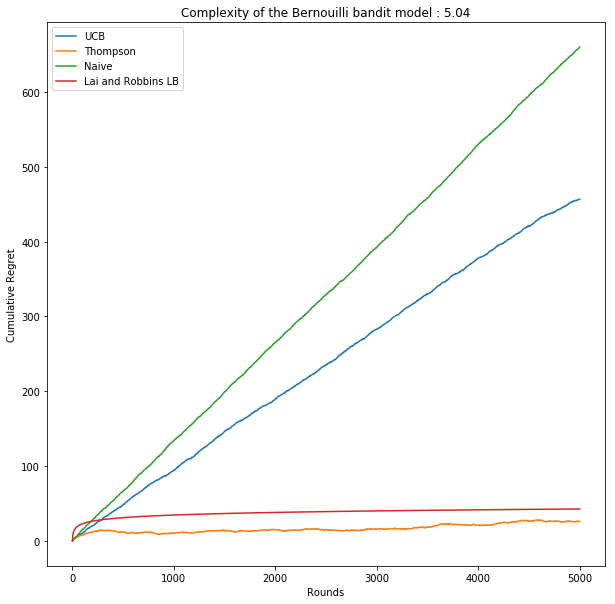

In [30]:
#Not complex Bernoulli MAB
MAB = BernoulliBanditModel([0.7,0.5,0.4,0.3])
simulate_and_plot_regrets(MAB.arms,Bernoulli=True, T = 5000, nb_simul = 20)

I first chose to build a Bernoulli Bandit Model with low complexity (5.04) : 4 arms with respective probabilities [0.7, 0.5, 0.4, 0.3] (the best arm gives a mean reward larger by 0.2 to the second best). 

The cumulated regrets shown were averaged on 20 simulations for each algorithm (UCB,Thompson,Naive). $\rho=0.2$ was chosen for UCB algorithm (value advised in the course).

- We observe that the Bayesian approach of Thompson Sampling gives lower cumulated regrets than UCB algorithm. Also, we observe as expected that Naive algorithm gives a much higher regret than UCB (Naive does not explore at all ie. it chooses almost immediately its arm).


- Lai and Robbins lower bound goes below UCB cumulated regrets from round 100, but Thompson Sampling is still slightly below Lai Robbins lower bound even at round 5000. This is not a contradiction : we should remember that Lai and Robbins lower bound is an asymptotic lower bound, while we chose here a T=5000 horizon.

means: [0.3, 0.28, 0.27, 0.26]


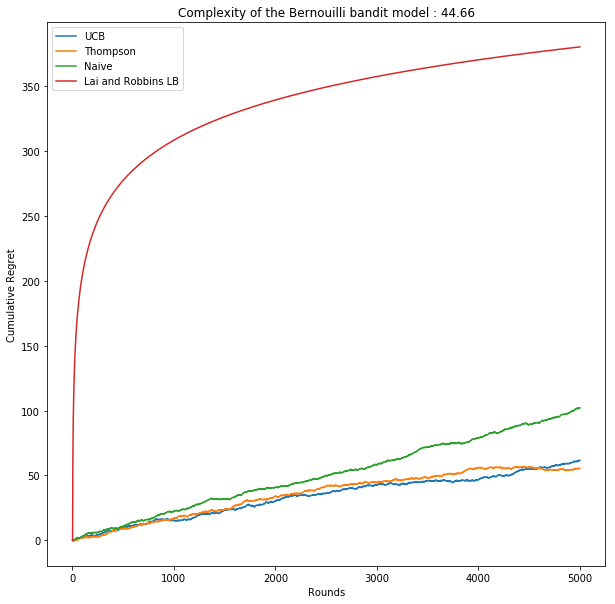

In [31]:
#Complex Bernoulli MAB
MAB = BernoulliBanditModel([0.30,0.28,0.27,0.26])
simulate_and_plot_regrets(MAB.arms,Bernoulli=True, T = 5000, nb_simul = 20)

I then chose to build a Bernoulli Bandit Model with higher complexity (44.66) : 4 arms with respective probabilities  [0.3, 0.28, 0.27, 0.26] (the best arm gives a mean reward larger by only 0.02 to the second best). 

The cumulated regrets shown were averaged on 20 simulations for each algorithm.

- We observe that Thompson Sampling and UCB algorithms give here very similar cumulated regrets. Difference with respect to Naive is also lower compared to the previous easy bandit model (Naive regrets less choosing a suboptimal arm).


- Lai and Robbins lower bound is much higher than the cumulated regrets of any algorithm (Naive, UCB, Thompson). Therefore, it is not a very useful lower bound for a complex problem (we should wait for an almost infinite number of rounds to see the cumulated regrets of one algorithm go above the lower bound).

## Question 2 - Non-parametric bandit (bounded rewards)

means: [0.3, 0.3333333333333333, 0.2809376368420774, 0.30000000000000004]


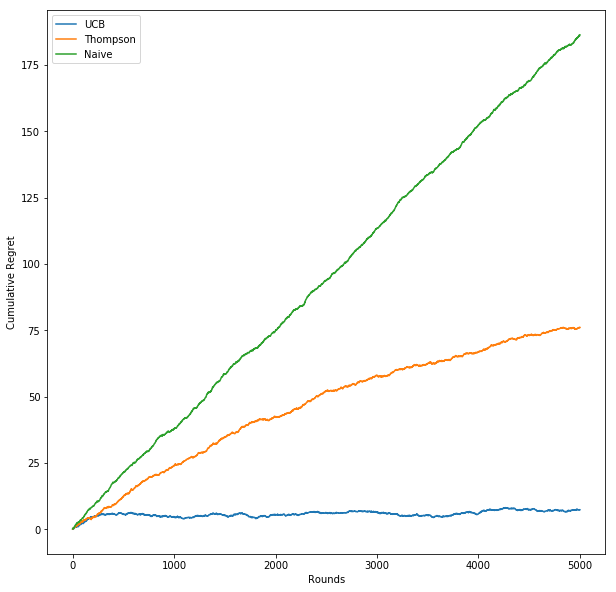

In [16]:
class NonParametricBanditModel():
    def __init__(self):
        arm1 = ArmBernoulli(0.3, random_state=np.random.randint(1, 312414))
        arm2 = ArmBeta(1, 2, random_state=np.random.randint(1, 312414))
        arm3 = ArmExp(3., 1, random_state=np.random.randint(1, 312414))
        arm4 = ArmFinite(np.array([0.,0.5,1.]),np.array([0.6,0.2,0.2]), random_state=np.random.randint(1, 312414))
        self.arms = [arm1, arm2, arm3, arm4]

MAB = NonParametricBanditModel()
simulate_and_plot_regrets(MAB.arms,Bernoulli=False, T = 5000, nb_simul = 20)

- As for the non-parametric MAB, I chose the four following arms : a Bernouilli arm (probability 0.3), a Beta arm (wit parameters $a=1,b=2$), an Exponential Arm ($\lambda=3$ and truncated at 1 to have reward between 0 and 1), and a Finite-Support Arm (rewards of [0.,0.5,1.] with respective probabilities [0.6,0.2,0.2]). The means of the four arms are respectively [0.30, 0.33, 0.28, 0.30] (2-digits rounded values).

  For this model, we see that UCB achieves lowest cumulated regrets than Thompson samplings.


- As proposed in [Agrawal and Goyal, 2012], we can adapt the standard Thompson algorithm to handle non-binary rewards (between 0 and 1), by sampling a Bernouilli of success probability the sampled reward (between 0 and 1) given by the chosen arm, and updating as in the binary case the posterior probability (ie. adding 1 to the number of successes or failures depending on the result of the Bernouilli sample).


- [Burnetas and Katehakis, 1996] showed that we can still define a notion of complexity under no parametric assumptions (see pages 2,7,8) :

$$ \lim_{n \rightarrow \infty} \frac{R_n}{\log n} \geq \frac{\sum_i \mu^*(\theta) - \mu_i(\theta_i)}{\inf_{\theta_i', \mu^*(\theta) < \mu_i(\theta_i')} KL(\theta_i,\theta_i')}$$

   However, we would have to compute the KL divergences between the various types of distributions chosen to plot the "oracle" regret curve (the KL divergence formula given in the assignment only holds for two Bernouilli distributions). 



# Exercise 2 - Linear Bandit on Real Data

## Question 3

In [5]:
def simulate_algo(model,T,algo,eps=None,lambd=1.,alpha=None):
    # returns a tuple with the regrets and the norm2-distances between estimated 
    # and true Theta for one simulation of the algorithm algo on the model
    # algo must be 'Random','EpsGreedy' or 'LinUCB'
    # eps must be set for 'Eps-Greedy' algorithm (tradeoff explore/exploit)
    # alpha must be set for 'LinUCB' algorithm (confidence level)
    # lambd must be set up for any algorithm (weight regularization, to estimate theta)

    n_a = model.n_actions
    d = model.n_features
    
    regret = np.zeros(T)    #regrets
    norm_dist = np.zeros(T) #norm2-distances between estimated and true theta
    
    #EpsGreedy needs empirical means to choose its arms
    if algo=="EpsGreedy":
        nbPulls = np.zeros(n_a)
        totalReward = np.zeros(n_a)
        meanReward = np.zeros(n_a)  # empirical means
    
    #variables useful to compute efficiently new estimates of theta and LinUCB action
    At = lambd*np.eye(d)
    bt = np.zeros(d)
    theta_hat = np.zeros(d) #estimate of theta
    
    for t in range(T):
    
        # choose action
        if algo == "LinUCB": #maximizing upper bound on expected reward
            expected_reward = np.dot(model.features,theta_hat)
            optimist_margin = np.array([model.features[a,:].dot(np.linalg.inv(At)).dot(model.features[a,:].T) for a in range(n_a)])
            optimist_margin = alpha*np.sqrt(optimist_margin)
            a_t = np.argmax(expected_reward + optimist_margin)

        elif algo == "Random": #choose action randomly
            a_t = np.random.randint(n_a)

        elif algo == "EpsGreedy": #follow eps-greedy policy
            u = np.random.rand()
            if u < eps:
                a_t = np.random.randint(n_a)
            else:
                a_t = np.argmax(meanReward)
        else:
            print("algo should be 'Random','EpsGreedy' or 'LinUCB'")
            exit()

        #observe reward
        r_t = model.reward(a_t)
        
        if algo == "EpsGreedy": #update empirical means
            nbPulls[a_t] += 1
            totalReward[a_t] += r_t
            meanReward[a_t] = totalReward[a_t] / nbPulls[a_t]

        #update theta_hat
        At += np.outer(model.features[a_t, :],model.features[a_t, :])
        bt += r_t * model.features[a_t, :]
        theta_hat = np.linalg.inv(At).dot(bt)

        #save regret and dist between true and estimated theta
        regret[t] = model.best_arm_reward() - r_t
        norm_dist[t] = np.linalg.norm(theta_hat - model.real_theta, 2)
        
    return regret, norm_dist

In [6]:
def simulate(model,nb_simul,T,eps=0.1,lambd=1.,alpha=1.):
    # simulate the three algorithms "Random", "EpsGreedy" and "LinUCB" on the model
    # nb_simul times over horizon T
    # returns two dictionnaries storing for each algorithm
    # the cumulated regrets and the distance between estimated and true theta 

    alg_names = ['Random','EpsGreedy','LinUCB']
    regret_cum = {} #mean cumulated regret over nb_simul for each algorithm
    norm_dist = {} #mean norm_dist over nb_simul for each algorithm

    for alg_name in alg_names:

        # compute average (over sim) of the algorithm performance and plot it

        regret_cum[alg_name] = np.zeros(T)
        norm_dist[alg_name] = np.zeros(T)

        for k in tqdm(range(nb_simul), desc="Simulating {}".format(alg_name)):
            if alg_name=='Random':
                reg, norm_d = simulate_algo(model, T, alg_name, lambd=lambd)
            elif alg_name=='EpsGreedy':
                reg, norm_d = simulate_algo(model, T, alg_name, lambd=lambd, eps=eps)
            elif alg_name=='LinUCB':
                reg, norm_d = simulate_algo(model, T, alg_name, lambd=lambd, alpha=alpha)
            regret_cum[alg_name] += reg
            norm_dist[alg_name] += norm_d

        regret_cum[alg_name] /= nb_simul
        norm_dist[alg_name] /= nb_simul
        
    for alg_name in alg_names:
        regret_cum[alg_name] = regret_cum[alg_name].cumsum()
        
    return regret_cum, norm_dist

In [22]:
random_state = np.random.randint(0, 24532523)

model = ToyLinearModel(
       n_features=8,
       n_actions=20,
       random_state=random_state,
       noise=0.1)
    
nb_simul = 20
T = 5000
regret_cum, norm_dist = simulate(model,nb_simul,T,eps=0.4,lambd=1.,alpha=5.)

Simulating LinUCB: 100%|██████████| 20/20 [01:43<00:00,  5.38s/it]


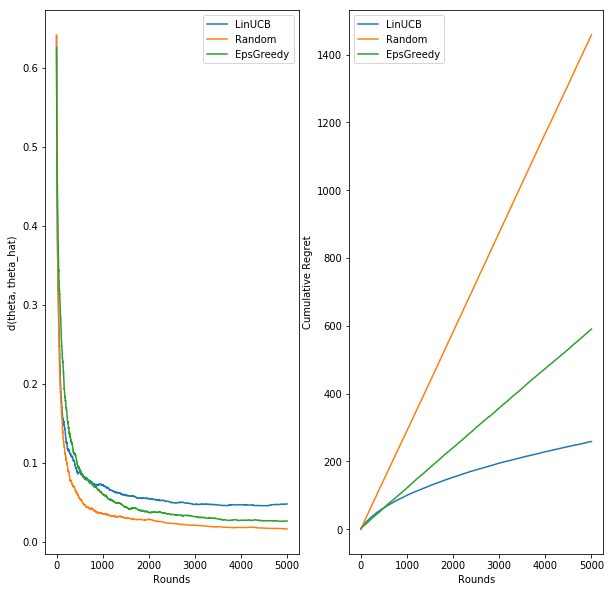

In [23]:
plt.figure(1)
plt.subplot(121)
for alg_name in norm_dist.keys():
    plt.plot(norm_dist[alg_name], label=alg_name)
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Rounds')
plt.legend()

plt.subplot(122)
for alg_name in norm_dist.keys():
    plt.plot(regret_cum[alg_name], label=alg_name)
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()

plt.show()

The curve plotted is relative to the Toy model, and the quantities shown were averaged over 20 simulations of each algorithm (Random, 0.4-greedy policy and LinUCB). L2-regularization weight $\lambda$ for the estimation of $\theta$ was set to 1. $\alpha$ parameter  linked to the level of confidence of the interval for the estimated reward was set to 5. (and horizon was set to 5000 for computation time reasons).

We approach the true $\theta$ with the three algorithms.  And the better the estimated $\theta$ (the more exploration), the higher the cumulated regret (the less exploitation). 

And if we had chosen a lower $\alpha$ for LinUCB (such as $\alpha=1$), we would have observed a much lower cumulated regret but the distance between estimated and true $\theta$ would not have converged at all towards 0 (less exploration, more exploitation).

In [32]:
random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(
         random_state=random_state,
         noise=0.1)

nb_simul = 20
T = 5000
regret_cum, norm_dist = simulate(model,nb_simul,T,eps=0.4,lambd=1.,alpha=100.)


Simulating Random: 100%|██████████| 20/20 [00:21<00:00,  1.51s/it]

Simulating EpsGreedy: 100%|██████████| 20/20 [00:37<00:00,  2.42s/it]

Simulating LinUCB: 100%|██████████| 20/20 [38:32<00:00, 116.11s/it]


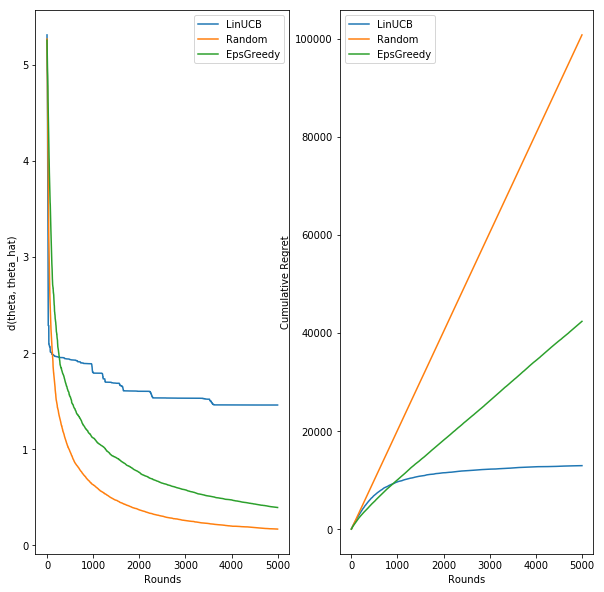

In [34]:
plt.figure(1)
plt.subplot(121)
for alg_name in norm_dist.keys():
    plt.plot(norm_dist[alg_name], label=alg_name)
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Rounds')
plt.legend()

plt.subplot(122)
for alg_name in norm_dist.keys():
    plt.plot(regret_cum[alg_name], label=alg_name)
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()

plt.show()

The curve plotted above is relative to the MovieLens model, and the quantities shown were averaged over 20 simulations of each algorithm (Random, 0.4-greedy policy and LinUCB). L2-regularization weight  $\lambda$ for the estimation of $\theta$ was set to 1. $\alpha$ parameter linked to the level of confidence of the interval for the estimated reward was set to 100. (and horizon was set to 5000 for computation time reasons).

We observe that LinUCB with $\alpha$ = 100 achieves the lowest regret, followed by 0.4-greedy policy, followed by Random policy. While Random policy achieves the best estimate for $\theta$, followed by 0.4-greedy policy, followed by LinUCB. The better the estimated $\theta$ (the more exploration), the higher the cumulated regret (the less exploitation).

This was expected : Random algorithm never exploits, hence the very high regret, but always explores, hence it ends by knowing perfectly the preferences of the user (very good estimate of $\theta$). 0.4-greedy Policy exploits 60% of the time (explores 40%). LinUCB explores just enough to understand which arm is the best (for the confidence level linked to $\alpha$).

